## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
import lightgbm as lgb
import xgboost as xgb
# import timeb
from collections import Counter
import datetime
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
import eli5
import shap
from IPython.display import HTML
import json
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from sklearn import metrics
from typing import Any
from itertools import product
import re
from tqdm import tqdm
from joblib import Parallel, delayed

random_seed = 33

Using TensorFlow backend.


In [2]:
# train = pd.read_csv('../data/preprocess/train895.csv')
# test = pd.read_csv('../data/preprocess/test895.csv')
# # train = pd.read_csv('../data/preprocess/train_1225.csv')
# # test = pd.read_csv('../data/preprocess/test_1225.csv')
train = pd.read_csv('../data/preprocess/train_1225_2.csv')
test = pd.read_csv('../data/preprocess/test_1225_2.csv')

## Helper function

In [3]:
def cut_pred(pr1: np.array, coef: list):
    assert len(coef)==3
    pr1[pr1 <= coef[0]] = 0
    pr1[np.where(np.logical_and(pr1 > coef[0], pr1 <= coef[1]))] = 1
    pr1[np.where(np.logical_and(pr1 > coef[1], pr1 <= coef[2]))] = 2
    pr1[pr1 > coef[2]] = 3
    
    return pr1

## custom eval_metrics

In [4]:
from sklearn.metrics import cohen_kappa_score

## https://github.com/catboost/tutorials/blob/master/custom_loss/custom_loss_and_metric_tutorial.ipynb
class qwk(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is list of indexed containers
        # (containers with only __len__ and __getitem__ defined), one container
        # per approx dimension. Each container contains floats.
        # weight is one dimensional indexed container.
        # target is float.   
        # weight parameter can be None.
        # Returns pair (error, weights sum)

        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 1.0
        y_true = []
        y_pred = []
        for i in range(len(approx)):
            y_true.append(target[i])
            y_pred.append(approx[i])
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        
        y_pred[y_pred <= 1.12232214] = 0
        y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
        y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
        y_pred[y_pred > 2.22506454] = 3
        
        error_sum = cohen_kappa_score(y_true, y_pred,weights='quadratic')
#         error_sum = qwk(y_true, y_pred)
        
        return error_sum, weight_sum

@jit
def qwk_np(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred2 = y_pred.copy()
    y_pred2[y_pred2 <= 1.12232214] = 0
    y_pred2[np.where(np.logical_and(y_pred2 > 1.12232214, y_pred2 <= 1.73925866))] = 1
    y_pred2[np.where(np.logical_and(y_pred2 > 1.73925866, y_pred2 <= 2.22506454))] = 2
    y_pred2[y_pred2 > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'qwk', qwk_np(y_true, y_pred2), True

def eval_qwk_lgb_regr2(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred2 = y_pred.copy()
    y_pred2[y_pred2 <= 0.5] = 0
    y_pred2[np.where(np.logical_and(y_pred2 > 0.5, y_pred2 <= 1.5))] = 1
    y_pred2[np.where(np.logical_and(y_pred2 > 1.5, y_pred2 <= 2.5))] = 2
    y_pred2[y_pred2 > 2.5] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'qwk2', qwk_np(y_true, y_pred2), True

In [5]:
def find_col(df, cols):
    ## return the index of cols in df.columns, ignore if col not exit
    cols2 = []
    for c in cols:
        if c in df.columns:
            cols2.append(c)
    return cols2

In [6]:
## k-fold cv

cat_cols = ['title','world','timestamp_weekday']
drop_cols = ['installation_id', 'game_session', 'timestamp', 'accuracy_group']
cat_cols= find_col(train, cat_cols)
drop_cols = find_col(train, drop_cols)

y = train['accuracy_group']
X = train.drop(columns=drop_cols)

n_fold = 5
folds = GroupKFold(n_splits=n_fold)

for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, train['installation_id'])):
    pass


In [7]:
import eli5
from eli5.sklearn import PermutationImportance

## Wrapper
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None, permutation=False):
        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
            del params['cat_cols']
        else:
            categorical_columns = 'auto'
        
#         eval_metric = lambda y_true, y_pred: [eval_qwk_lgb_regr(y_true, y_pred), eval_qwk_lgb_regr2(y_true, y_pred)]
        eval_metric = eval_qwk_lgb_regr

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_
        
        if permutation:
#             perm = PermutationImportance(self.model, random_state=self.random_seed).fit(X_valid, y_valid)
            perm = PermutationImportance(self.model).fit(X_valid, y_valid)
            self.feature_importances2_ = pd.DataFrame({'feature':X_valid.columns.tolist(),'importance':perm.feature_importances_})

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)


class CatboostWrapper_regr(object):
    """
    A wrapper for catboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = CatBoostRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None, permutation=False):
        
        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
            del params['cat_cols']
        else:
            categorical_columns = None

        eval_set = []
        eval_names = []
        self.model = self.model.set_params(**params)
        self.model = self.model.set_params(eval_metric=qwk())
        
        
        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')
        elif X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')
        else:
            eval_set.append((X_train, y_train))
            eval_names.append('train')

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.get_best_score()
        
        test_pool=Pool(X_valid, y_valid,cat_features=categorical_columns)
        self.feature_importances_ = self.model.get_feature_importance(test_pool,thread_count=4)

    def predict(self, X_test):
        return self.model.predict(X_test, ntree_end=self.model.get_best_iteration())


from sklearn.base import BaseEstimator, TransformerMixin
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):
#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [22]:
class RegressorModel(object):
    """
    A wrapper class for regression models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).
    """

    def __init__(self, columns: list=None, model_wrapper=None, random_state=33):
        """
        :param columns: columns to train
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.random_seed = random_state
        
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            X_append: pd.DataFrame = None, y_append: pd.DataFrame = None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True,
            permutation=False):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=self.random_seed)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        ## model FI and permutation FI
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.feature_importances_p = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]
        if X_append is not None:
            X_append = X_append[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
                
            print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = pd.concat([X.iloc[train_index],X_append],axis=0), X.iloc[valid_index]
            y_train, y_valid = pd.concat([y.iloc[train_index],y_append],axis=0), y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

#             if adversarial:
#                 X_new1 = X_train.copy()
#                 if X_valid is not None:
#                     X_new2 = X_valid.copy()
#                 elif X_holdout is not None:
#                     X_new2 = X_holdout.copy()
#                 X_new = pd.concat([X_new1, X_new2], axis=0)
#                 y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
#                 X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params.copy(), permutation=permutation)
            self.folds_dict[fold_n]['scores'] = model.best_score_
            
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            if permutation:
                fold_importance_p = pd.DataFrame(list(zip(X_train.columns, model.feature_importances2_)),
                                               columns=['feature', 'importance'])
                self.feature_importances_p = self.feature_importances.append(fold_importance_p)
            
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(float)
        if permutation:
            self.feature_importances_p['importance'] = self.feature_importances_p['importance'].astype(float)

        self.calc_scores_()
        
        if plot:
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')
        print(feature_importances.sort_values(by='importance'))

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10, fi_type=1):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        fi = self.feature_importances
        if fi_type=='p':
            fi = self.feature_importances_p
            
        grouped_feats = fi.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')


In [23]:
lgb_params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 50,
            'early_stopping_rounds': 100, 
#             'eval_metric': lgb_kappa_eval,
#             'eval_metric': ['qwk','qwk2','qwk3']
            }

cat_params = {'iterations':2000,
            'loss_function': 'RMSE',
            'verbose': 50,
            'early_stopping_rounds': 100, 
#             'task_type':"GPU",
#             'devices':'0:1',
            }

para_tune = {'feature_fraction': 0.9985706623844444, 'lambda_l1': 1.3464702887971034, 'lambda_l2': 24.03486401669668, 'max_depth': 9, 'num_leaves': 20, 'subsample': 0.9982720526777418, 'subsample_freq': 2}
for k in para_tune:
    lgb_params[k] = para_tune[k]

In [24]:
train = train.fillna(-10)

Fold 1 started at Thu Jan  2 16:29:53 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.985529	train's qwk: 0.612855	valid's rmse: 0.99937	valid's qwk: 0.599338
[100]	train's rmse: 0.942048	train's qwk: 0.646457	valid's rmse: 0.974508	valid's qwk: 0.615036
[150]	train's rmse: 0.917037	train's qwk: 0.666336	valid's rmse: 0.969122	valid's qwk: 0.615417
[200]	train's rmse: 0.897854	train's qwk: 0.682371	valid's rmse: 0.966505	valid's qwk: 0.61683
[250]	train's rmse: 0.881067	train's qwk: 0.69831	valid's rmse: 0.96471	valid's qwk: 0.619514
[300]	train's rmse: 0.86575	train's qwk: 0.709652	valid's rmse: 0.964355	valid's qwk: 0.621679
[350]	train's rmse: 0.851416	train's qwk: 0.721973	valid's rmse: 0.964547	valid's qwk: 0.624219
Early stopping, best iteration is:
[276]	train's rmse: 0.872851	train's qwk: 0.704998	valid's rmse: 0.964115	valid's qwk: 0.61928
Fold 2 started at Thu Jan  2 16:30:00 2020
Training until validation scores don't improve for 100 r

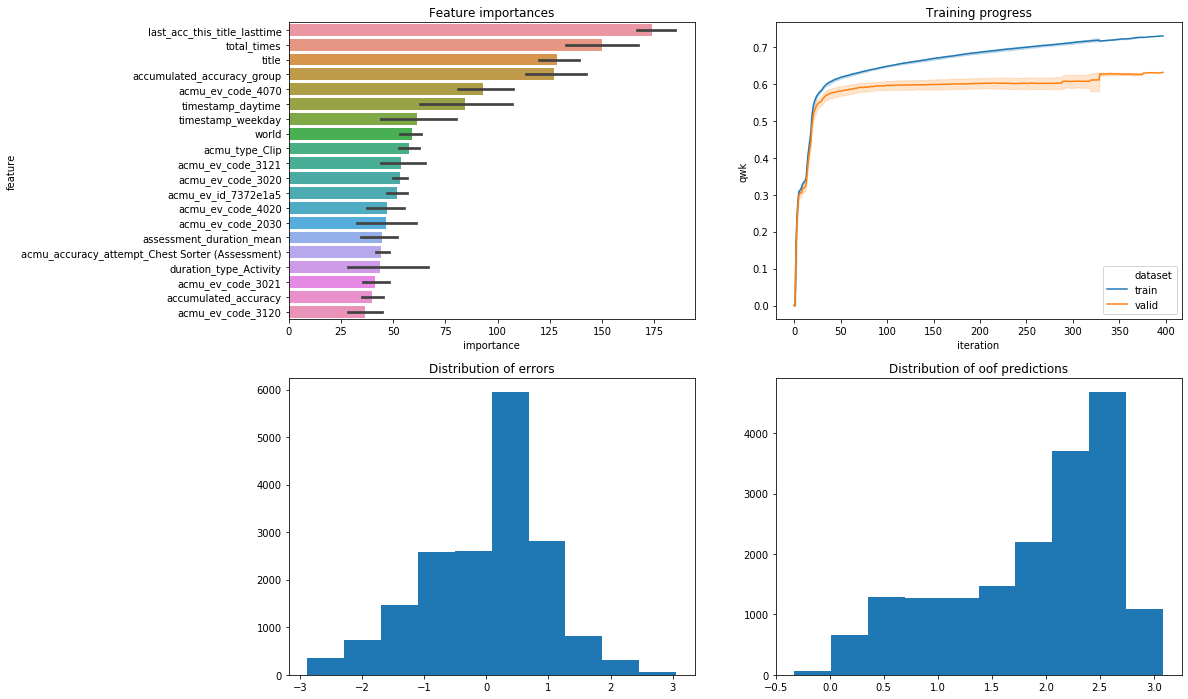

In [27]:
y = train['accuracy_group']
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

cat_cols = ['title','world','timestamp_weekday']
cols_to_drop = ['installation_id', 'game_session', 'timestamp', 'accuracy_group']
cat_params['cat_cols'] = cat_cols
lgb_params['cat_cols'] = cat_cols


mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=train, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)
# regressor_model1 = RegressorModel(model_wrapper=CatboostWrapper_regr())
# regressor_model1.fit(X=train, y=y, folds=folds, params=cat_params, preprocesser=mt, transformers=transformers,
#                     eval_metric='qwk', cols_to_drop=cols_to_drop)

Fold 1 started at Thu Jan  2 15:59:58 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.988053	train's qwk: 0.608357	valid's rmse: 0.999862	valid's qwk: 0.59497
[100]	train's rmse: 0.945047	train's qwk: 0.641877	valid's rmse: 0.975818	valid's qwk: 0.611418
[150]	train's rmse: 0.921113	train's qwk: 0.660561	valid's rmse: 0.969576	valid's qwk: 0.615574
[200]	train's rmse: 0.902561	train's qwk: 0.678503	valid's rmse: 0.966612	valid's qwk: 0.618015
[250]	train's rmse: 0.886953	train's qwk: 0.691315	valid's rmse: 0.965299	valid's qwk: 0.621128
[300]	train's rmse: 0.872557	train's qwk: 0.702332	valid's rmse: 0.965172	valid's qwk: 0.618584
Early stopping, best iteration is:
[246]	train's rmse: 0.888019	train's qwk: 0.690347	valid's rmse: 0.965067	valid's qwk: 0.621658
Fold 2 started at Thu Jan  2 16:01:46 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.988005	train's qwk: 0.607082	valid's rmse: 1.00319	valid's qwk: 

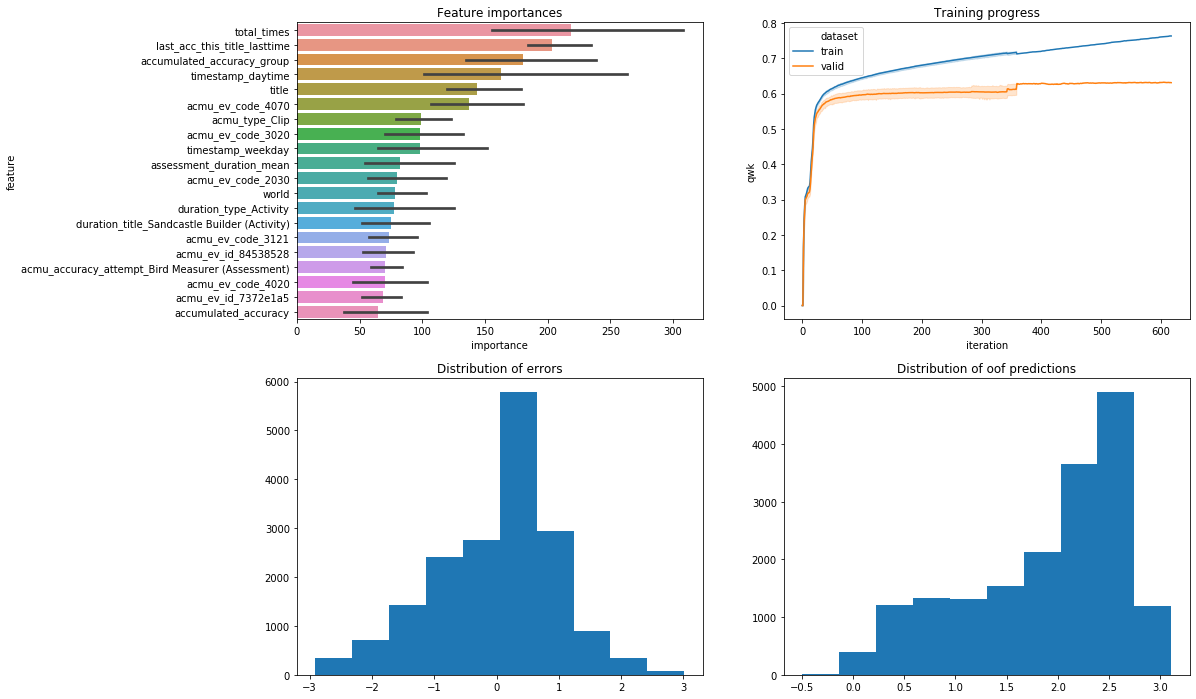

In [12]:
## feature selection
## permutation = True or False
select_col = regressor_model1.get_top_features(top_n=100,fi_type='n')

regressor_model2 = RegressorModel(columns=select_col+['installation_id'],model_wrapper=LGBWrapper_regr())
regressor_model2.fit(X=train, y=y, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)

In [13]:
select_col.sort()
select_col

['accumulated_accuracy',
 'accumulated_accuracy_group',
 'acmu_acc_gp_0',
 'acmu_accuracy_attempt_Bird Measurer (Assessment)',
 'acmu_accuracy_attempt_Cart Balancer (Assessment)',
 'acmu_accuracy_attempt_Cauldron Filler (Assessment)',
 'acmu_accuracy_attempt_Chest Sorter (Assessment)',
 'acmu_accuracy_attempt_Mushroom Sorter (Assessment)',
 'acmu_ev_code_2000',
 'acmu_ev_code_2010',
 'acmu_ev_code_2020',
 'acmu_ev_code_2030',
 'acmu_ev_code_3010',
 'acmu_ev_code_3020',
 'acmu_ev_code_3021',
 'acmu_ev_code_3110',
 'acmu_ev_code_3120',
 'acmu_ev_code_3121',
 'acmu_ev_code_4020',
 'acmu_ev_code_4022',
 'acmu_ev_code_4025',
 'acmu_ev_code_4030',
 'acmu_ev_code_4035',
 'acmu_ev_code_4040',
 'acmu_ev_code_4070',
 'acmu_ev_code_4090',
 'acmu_ev_code_4100',
 'acmu_ev_code_4220',
 'acmu_ev_id_00c73085',
 'acmu_ev_id_04df9b66',
 'acmu_ev_id_0db6d71d',
 'acmu_ev_id_1325467d',
 'acmu_ev_id_15a43e5b',
 'acmu_ev_id_1af8be29',
 'acmu_ev_id_250513af',
 'acmu_ev_id_363c86c9',
 'acmu_ev_id_3bf1cf26',
 'acmu_ev_id_3ee399c3',
 'acmu_ev_id_461eace6',
 'acmu_ev_id_499edb7c',
 'acmu_ev_id_562cec5f',
 'acmu_ev_id_565a3990',
 'acmu_ev_id_587b5989',
 'acmu_ev_id_6bf9e3e1',
 'acmu_ev_id_7372e1a5',
 'acmu_ev_id_7da34a02',
 'acmu_ev_id_7dfe6d8a',
 'acmu_ev_id_84538528',
 'acmu_ev_id_884228c8',
 'acmu_ev_id_9e34ea74',
 'acmu_ev_id_a7640a16',
 'acmu_ev_id_acf5c23f',
 'acmu_ev_id_b012cd7f',
 'acmu_ev_id_b120f2ac',
 'acmu_ev_id_c51d8688',
 'acmu_ev_id_c58186bf',
 'acmu_ev_id_ca11f653',
 'acmu_ev_id_cb6010f8',
 'acmu_ev_id_cf82af56',
 'acmu_ev_id_e694a35b',
 'acmu_ev_id_f5b8c21a',
 'acmu_title_Cart Balancer (Assessment)',
 'acmu_title_Crystal Caves - Level 2',
 'acmu_title_Crystal Caves - Level 3',
 'acmu_type_Assessment',
 'acmu_type_Clip',
 'acmu_world_CRYSTALCAVES',
 'acmu_world_TREETOPCITY',
 'assessment_duration_mean',
 'duration_title_All Star Sorting',
 'duration_title_Bottle Filler (Activity)',
 'duration_title_Bug Measurer (Activity)',
 'duration_title_Cart Balancer (Assessment)',
 'duration_title_Cauldron Filler (Assessment)',
 'duration_title_Chest Sorter (Assessment)',
 'duration_title_Chicken Balancer (Activity)',
 'duration_title_Chow Time',
 'duration_title_Dino Drink',
 'duration_title_Fireworks (Activity)',
 'duration_title_Flower Waterer (Activity)',
 'duration_title_Mushroom Sorter (Assessment)',
 'duration_title_Sandcastle Builder (Activity)',
 'duration_title_Watering Hole (Activity)',
 'duration_type_Activity',
 'duration_type_Assessment',
 'duration_type_Game',
 'duration_world_1',
 'duration_world_2',
 'duration_world_3',
 'event_code_class_count',
 'event_id_class_count',
 'last_acc_all',
 'last_acc_this_title_lasttime',
 'timestamp_daytime',
 'timestamp_weekday',
 'title',
 'title_class_count',
 'total_event_count',
 'total_times',
 'world']

Fold 1 started at Thu Jan  2 16:28:53 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.965922	train's qwk: 0.62717	valid's rmse: 0.99733	valid's qwk: 0.598834
[100]	train's rmse: 0.923825	train's qwk: 0.654108	valid's rmse: 0.97365	valid's qwk: 0.615883
[150]	train's rmse: 0.900439	train's qwk: 0.67211	valid's rmse: 0.966243	valid's qwk: 0.623806
[200]	train's rmse: 0.883223	train's qwk: 0.688704	valid's rmse: 0.963781	valid's qwk: 0.624255
[250]	train's rmse: 0.868046	train's qwk: 0.702176	valid's rmse: 0.962768	valid's qwk: 0.626855
[300]	train's rmse: 0.854176	train's qwk: 0.713058	valid's rmse: 0.961677	valid's qwk: 0.621978
Early stopping, best iteration is:
[247]	train's rmse: 0.86886	train's qwk: 0.701403	valid's rmse: 0.962593	valid's qwk: 0.628037
Fold 2 started at Thu Jan  2 16:28:55 2020
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.965654	train's qwk: 0.627322	valid's rmse: 0.999729	valid's qwk: 0.6

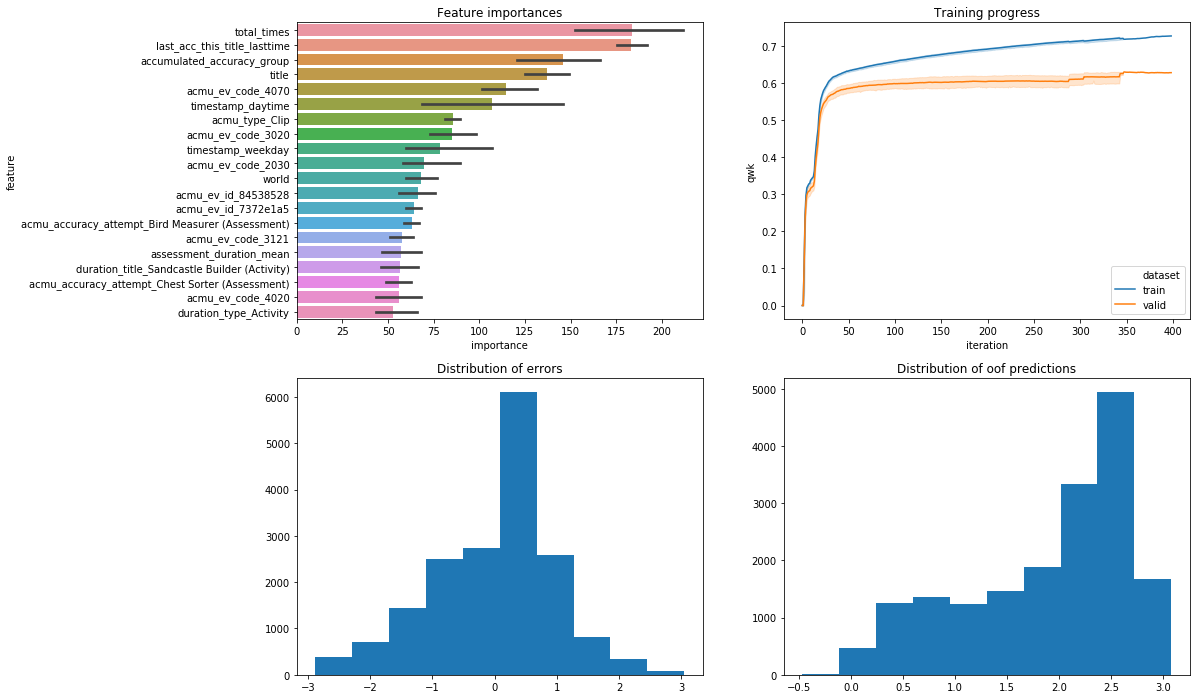

In [26]:
## semi-supervised learning
coef = [1.12232214,1.73925866,2.22506454]
y_test_pred = regressor_model2.predict(test)
y_test_pred = cut_pred(y_test_pred,coef)
X_append = test
y_append = pd.Series(y_test_pred.flatten())

regressor_model3 = RegressorModel(columns=select_col+['installation_id'],model_wrapper=LGBWrapper_regr())
regressor_model3.fit(X=train, y=y, X_append=X_append, y_append=y_append, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)

In [ ]:
## semi-supervised learning
## add train

coef = [1.12232214,1.73925866,2.22506454]
y_train_pseudo_pred = regressor_model2.predict(train_pseudo)
y_train_pseudo_pred = cut_pred(y_train_pseudo_pred,coef)
X_append = pd.concat([test,train_pseudo],axis=0)
y_append = pd.concat([pd.Series(y_test_pred.flatten()),pd.Series(y_train_pseudo_pred.flatten())]).reset_index(drop=True)

regressor_model4 = RegressorModel(columns=select_col+['installation_id'],model_wrapper=LGBWrapper_regr())
regressor_model4.fit(X=train2, y=y2, X_append=X_append, y_append=y_append, folds=folds, params=lgb_params, preprocesser=mt, transformers=transformers,
                    eval_metric='qwk', cols_to_drop=cols_to_drop, permutation=False)

整理別人kernel中使用過的特徵

feature selection
* lasso?
* 相對訊息?

思考有哪些訓練方式:
有沒有比k-fold更好的?
semi-supervised learning? 將沒有assessment的使用者label加進訓練資料中
k-fold optimize th驗證結果

## Making predictions

The preprocessing is a class, which was initially written by Abhishek Thakur here: https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107 and later improved here https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved (the improvement is is speed).

It can be used to find optimal coefficients for thresholds. In this kernel I'll show an example, but when you do it, don't forget a proper validation.

In [15]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk_np(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [16]:
pr1 = regressor_model1.predict(train)

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

In [17]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk_np(y, opt_preds)

0.687759211658401

In [18]:
pr1 = cut_pred(pr1,coef)

In [19]:
def make_submission(sample_submission, pred, submit_file_name='submission.csv'):
    sample_submission['accuracy_group'] = pred.astype(int)
    sample_submission.to_csv(submit_file_name, index=False)
    print(sample_submission['accuracy_group'].value_counts(normalize=True))
    
make_submission(sample_submission=sample_submission, pred=pr1, submit_file_name='submission.csv')

NameError: name 'sample_submission' is not defined